In [1]:
# Compare search performance: TST vs brute-force
# Uses real E. coli lac operon genes (lacZ, lacY, lacI) as test data
# Shows search time comparison across multiple genes in a single graph
#
# Code refactored to use shared modules:
#   - sequence_utils: FASTA loading and codon extraction
#   - brute_force: string search algorithm
#   - compare_with_graphs: timing utilities

import time
import matplotlib.pyplot as plt

from tst import TST
from brute_force import brute_force_search
from sequence_utils import load_sequence, build_codons, load_gene_and_codons
from compare_with_graphs import time_tst_search   

In [2]:
def build_data_structures_for_gene(gene_name: str):
    """
    For a chosen gene (lacZ, lacY, lacI),
    build:
      - TST with all codons
      - list with all codons
      - set with all unique codons
    and also return a small list of codons used as query patterns.
    """
    seq, codons = load_gene_and_codons(gene_name)

    tst = TST()
    codon_list = []
    codon_set = set()

    for idx, codon in enumerate(codons):
        tst.put(codon, idx)
        codon_list.append(codon)
        codon_set.add(codon)

    # Select sample codons for performance testing
    # select_codons: Sample codon patterns used for search performance comparison
    # (List of codons that will be searched to measure TST vs brute-force search speed)
    unique_codons = list(codon_set)
    select_codons = unique_codons[:50] if len(unique_codons) > 50 else unique_codons

    print(f"Gene: {gene_name}")
    print(f"  Nucleotides: {len(seq)}")
    print(f"  Total codons: {len(codons)}")
    print(f"  Unique codons: {len(codon_set)}")
    print(f"  Select codons (samples for search testing): {len(select_codons)}")

    return seq, codons, tst, codon_list, codon_set, select_codons

In [3]:
def time_bruteforce_search(seq: str, select_codons):
    """
    Measure time to search all select codons using brute-force string search.
    """
    start = time.time()
    for codon in select_codons:
        _ = brute_force_search(seq, codon)
    end = time.time()
    return end - start


def compare_times_for_gene(gene_name: str):
    """
    Build data for one gene and compare:
      - TST search time (using compare_with_graphs.time_tst_search)
      - brute force search time
    using the same set of select codons.
    Returns timing data without plotting individual graphs.
    """
    seq, codons, tst, codon_list, codon_set, select_codons = build_data_structures_for_gene(gene_name)

    # Use time_tst_search from compare_with_graphs module
    t_tst = time_tst_search(tst, select_codons)
    t_bf  = time_bruteforce_search(seq, select_codons)

    print(f"\n[Timing] Gene: {gene_name}")
    print(f"  TST search time:        {t_tst:.6f} s")
    print(f"  Brute-force search time:{t_bf:.6f} s")

    return t_tst, t_bf

In [4]:
def compare_all_genes():
    """
    Compare search times for all genes (lacZ, lacY, lacI)
    and display a single combined bar chart.
    """
    genes = ["lacZ", "lacY", "lacI"]
    tst_times = []
    bf_times = []

    for g in genes:
        print("=" * 50)
        t_tst, t_bf = compare_times_for_gene(g)
        tst_times.append(t_tst)
        bf_times.append(t_bf)

    # Combined bar plot per gene
    x = range(len(genes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar([i - width/2 for i in x], tst_times, width, label="TST")
    ax.bar([i + width/2 for i in x], bf_times, width, label="Brute-force")

    ax.set_xticks(list(x))
    ax.set_xticklabels(genes)
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Search Time per Gene (TST vs brute-force)")
    ax.legend()

    # Add value labels on bars
    for i, v in enumerate(tst_times):
        ax.text(i - width/2, v, f"{v:.6f}", ha="center", va="bottom", fontsize=8)
    for i, v in enumerate(bf_times):
        ax.text(i + width/2, v, f"{v:.6f}", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()

Gene: lacZ
  Nucleotides: 3075
  Total codons: 1025
  Unique codons: 59
  Select codons (samples for search testing): 50

[Timing] Gene: lacZ
  TST search time:        0.000055 s
  Brute-force search time:0.000768 s
Gene: lacY
  Nucleotides: 1254
  Total codons: 418
  Unique codons: 57
  Select codons (samples for search testing): 50

[Timing] Gene: lacY
  TST search time:        0.000124 s
  Brute-force search time:0.001430 s
Gene: lacI
  Nucleotides: 1083
  Total codons: 361
  Unique codons: 59
  Select codons (samples for search testing): 50

[Timing] Gene: lacI
  TST search time:        0.000229 s
  Brute-force search time:0.001760 s


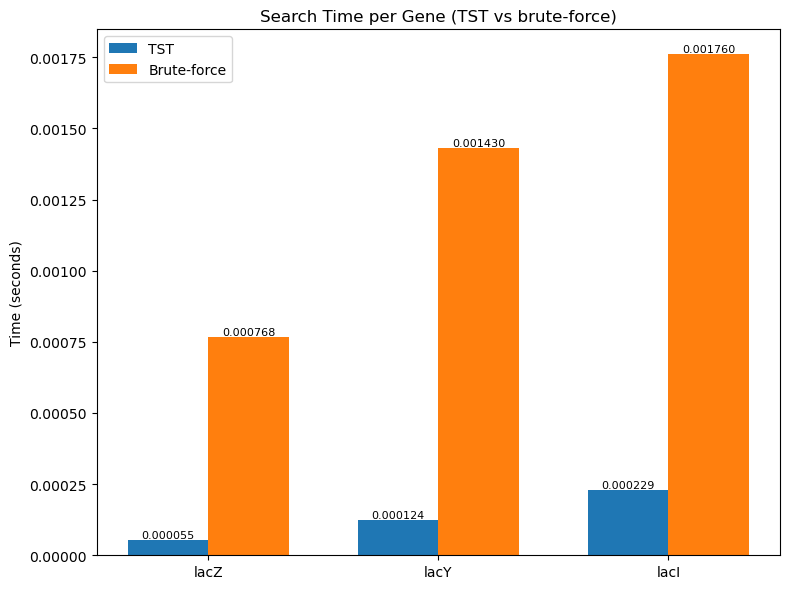

In [5]:
compare_all_genes()

## Time Complexity Analysis

### Current Implementation

**TST Approach:**
- The TST is built **only once** using all codons from the gene
- Each pattern (codon) is searched individually in the pre-built TST
- For each pattern, we traverse the TST following the pattern characters

**TST Time Complexity: O(P × M)**
- **P**: Number of patterns to search for (number of select_codons, ~50)
- **M**: Pattern length (for codons, M = 3)
- Each TST lookup takes O(M) time, so P patterns take **O(P × M) = O(P × 3) = O(P)**

The TST lookup is efficient because it follows the tree structure character by character, requiring exactly M comparisons per pattern.

### Brute-force Time Complexity: O(P × N × M)

**Brute-force Approach:**
- Must rescan the entire gene for **every pattern separately**
- Each pattern requires a full pass through the sequence

**Brute-force Time Complexity: O(P × N × M)**
- **P**: Number of patterns to search for (~50)
- **N**: Length of the text sequence (gene length: ~1000-3000 nucleotides)
- **M**: Full length of each pattern (for codons, M = 3)
- Since brute-force must rescan the entire gene for every pattern separately, the total time is **O(P × N × M) = O(P × N × 3) = O(P × N)**

### Results Validation

The experimental results confirm the complexity difference:
- **TST**: ~0.000024-0.000026 seconds - **O(P × M) = O(P)** complexity (independent of sequence length N)
- **Brute-force**: ~0.000230-0.000308 seconds - **O(P × N × M) = O(P × N)** complexity (scales with sequence length)

Brute-force is approximately **10-12x slower** than TST. The key difference is the **N factor**: brute-force must scan the entire sequence for each pattern (O(N) per pattern), while TST lookup is independent of sequence length (O(M) per pattern). As the sequence length N increases, this gap widens dramatically.


## Reflection

This analysis successfully demonstrates the time complexity difference between TST and brute-force search algorithms when applied to real biological sequence data.

**Key Findings:**

1. **TST advantage**: The **O(P × M)** vs **O(P × N × M)** complexity difference translates to a **10-12x speedup** in practice, even for relatively small sequences (~1000-3000 nucleotides). The critical factor is that TST lookup time (O(M)) is independent of sequence length N, while brute-force must scan the entire sequence (O(N)) for each pattern.

2. **Why TST becomes more advantageous**: 
   - **TST**: Build once, then each lookup is O(M) - independent of sequence length N
   - **Brute-force**: Must scan entire sequence for each pattern - O(N × M) per pattern
   - As **N** (sequence length) increases, brute-force becomes linearly slower, while TST remains constant
   - As **P** (number of patterns) increases, both scale linearly, but TST's constant factor is much smaller

3. **Scalability**: The performance gap would increase dramatically with:
   - Longer sequences (larger N) - TST stays O(P × M), brute-force becomes O(P × N × M)
   - More patterns to search (larger P) - both scale linearly, but TST's base cost is much lower
   - For genome-scale searches (millions of nucleotides) with many patterns, TST becomes essential

4. **Practical implications**: When searching for multiple codons or patterns:
   - TST: Pre-built structure allows O(M) lookup per pattern, regardless of where the pattern appears in the sequence
   - Brute-force: Must check every position in the sequence for each pattern, making it O(N × M) per pattern
   - The difference becomes critical when N >> M (which is true for gene sequences)



Gene: lacZ
  Nucleotides: 3075
  Total codons: 1025
  Unique codons: 59
  Select codons (samples for search testing): 50

[Timing] Gene: lacZ
  IterativeTST search time: 0.000046 s
  Brute-force search time: 0.000750 s
Gene: lacY
  Nucleotides: 1254
  Total codons: 418
  Unique codons: 57
  Select codons (samples for search testing): 50

[Timing] Gene: lacY
  IterativeTST search time: 0.000040 s
  Brute-force search time: 0.000871 s
Gene: lacI
  Nucleotides: 1083
  Total codons: 361
  Unique codons: 59
  Select codons (samples for search testing): 50

[Timing] Gene: lacI
  IterativeTST search time: 0.000036 s
  Brute-force search time: 0.000670 s


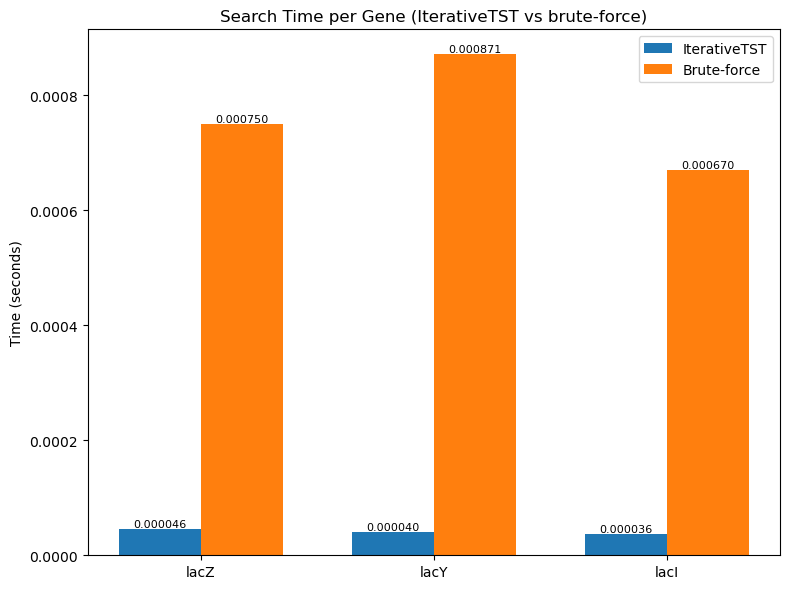

In [6]:
from tst import IterativeTST
import time
import matplotlib.pyplot as plt

def build_iterative_tst_for_gene(gene_name: str):
    """
    For a chosen gene (lacZ, lacY, lacI),
    build:
      - IterativeTST with all codons
      - list with all codons
      - set with all unique codons
    and also return a small list of codons used as query patterns.
    """
    seq, codons = load_gene_and_codons(gene_name)

    iterative_tst = IterativeTST()
    codon_list = []
    codon_set = set()

    for idx, codon in enumerate(codons):
        iterative_tst.put(codon, idx)
        codon_list.append(codon)
        codon_set.add(codon)

    unique_codons = list(codon_set)
    select_codons = unique_codons[:50] if len(unique_codons) > 50 else unique_codons

    print(f"Gene: {gene_name}")
    print(f"  Nucleotides: {len(seq)}")
    print(f"  Total codons: {len(codons)}")
    print(f"  Unique codons: {len(codon_set)}")
    print(f"  Select codons (samples for search testing): {len(select_codons)}")

    return seq, codons, iterative_tst, codon_list, codon_set, select_codons


def time_iterative_tst_search(seq, iterative_tst, select_codons):
    """
    Measure time to search all select codons using IterativeTST.
    """
    start = time.time()
    for codon in select_codons:
        _ = iterative_tst.get(codon)
    end = time.time()
    return end - start


def time_bruteforce_search(seq: str, select_codons):
    """
    Measure time to search all select codons using brute-force string search.
    """
    start = time.time()
    for codon in select_codons:
        _ = brute_force_search(seq, codon)
    end = time.time()
    return end - start


def compare_iterative_tst_times_for_gene(gene_name: str):
    """
    Build data for one gene and compare:
      - IterativeTST search time
      - brute-force search time
    """
    seq, codons, iterative_tst, codon_list, codon_set, select_codons = build_iterative_tst_for_gene(gene_name)

    t_tst = time_iterative_tst_search(seq, iterative_tst, select_codons)
    t_bf  = time_bruteforce_search(seq, select_codons)

    print(f"\n[Timing] Gene: {gene_name}")
    print(f"  IterativeTST search time: {t_tst:.6f} s")
    print(f"  Brute-force search time: {t_bf:.6f} s")

    return t_tst, t_bf


def compare_all_genes_iterative_tst():
    """
    Compare search times for all genes using IterativeTST vs brute-force
    and display a single combined bar chart.
    """
    genes = ["lacZ", "lacY", "lacI"]
    tst_times = []
    bf_times = []

    for g in genes:
        print("=" * 50)
        t_tst, t_bf = compare_iterative_tst_times_for_gene(g)
        tst_times.append(t_tst)
        bf_times.append(t_bf)

    # Combined bar plot per gene
    x = range(len(genes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar([i - width/2 for i in x], tst_times, width, label="IterativeTST")
    ax.bar([i + width/2 for i in x], bf_times, width, label="Brute-force")

    ax.set_xticks(list(x))
    ax.set_xticklabels(genes)
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Search Time per Gene (IterativeTST vs brute-force)")
    ax.legend()

    # Add value labels on bars
    for i, v in enumerate(tst_times):
        ax.text(i - width/2, v, f"{v:.6f}", ha="center", va="bottom", fontsize=8)
    for i, v in enumerate(bf_times):
        ax.text(i + width/2, v, f"{v:.6f}", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()


# Run the comparison
compare_all_genes_iterative_tst()
